In [59]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import os

In [60]:
def parseParameters(name):
    var_dict = {}

    param_tuple = name.split('__')

    for tuple in param_tuple:
        name, value = tuple.split('--')

        var_dict[name] = float(value)

    return var_dict

def generateCommand(struct_name, save="False"):
    params_str = struct_name.split("__")

    for i in range(len(params_str)):
        params_str[i] = params_str[i].replace("--", " ")
        params_str[i] = "--" + params_str[i]


    return " ".join(params_str) + " --s " + save


In [104]:
struct_name = "k--0.0001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"

args_dict =parseParameters(struct_name)

k = args_dict["k"]
phi = args_dict["phi"]
ksi = args_dict["ksi"]
cb = args_dict["cb"]
C_nmax = args_dict["Cn_max"]
lambd_nb = args_dict["lambd_nb"]
mi_n = args_dict["mi_n"]
lambd_bn = args_dict["lambd_bn"]
y_n = args_dict["y_n"]
t_lower = args_dict["t_lower"]
t_upper = args_dict["t_upper"]

size_t = int(((t_upper - t_lower) / (k)))

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t = torch.arange(t_lower, t_upper, k, requires_grad=True).reshape(-1, 1)

t_cpu = t

Steps in time = 100000



In [128]:
os.system("python3 edo_fdm_model.py " + generateCommand(struct_name, save="True"))

0

In [76]:
with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)


In [77]:
numpy_input = np.array([Cl, Cp]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = t.to(device)
    data_input = torch.tensor(numpy_input, dtype=torch.float32).to(device)

    print(device)

cuda


In [96]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
}

In [97]:
arch_str = "Tanh--16__Tanh--16__Tanh--16__Linear--16"

In [94]:
def generate_model(arch_str):

    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        activation, out_neurons = params.split("--")

        if len(modules) == 0:
            if activation == "Linear":
                modules.append(activation_dict[activation](1, int(out_neurons)))

            else:
                modules.append(nn.Linear(1, int(out_neurons)))
                modules.append(activation_dict[activation]())

        else:
            if activation == "Linear":
                modules.append(
                    activation_dict[activation](int(in_neurons), int(out_neurons))
                )

            else:
                modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                modules.append(activation_dict[activation]())

        in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [98]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=16, bias=True)
  (7): Linear(in_features=16, out_features=2, bias=True)
)


In [99]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [100]:
def pde(t, model):

    Cl, Cp = model(t).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [101]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

n_epochs = 500
batch_size = 10000
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):

        t_initial = torch.zeros_like(t[i : i + batch_size])

        C_initial_pred = model(t_initial)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        C_pred = model(t[i : i + batch_size])

        loss_pde = loss_fn(
            pde(t[i : i + batch_size], model), torch.cat([t_initial, t_initial], dim=1)
        )

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = loss_initial + loss_pde + loss_data
        # loss = loss_initial + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 0.0999029278755188
Finished epoch 100, latest loss 6.9341083872132e-05
Finished epoch 200, latest loss 7.271728827618062e-05
Finished epoch 300, latest loss 7.495821046177298e-05
Finished epoch 400, latest loss 7.540704245911911e-05


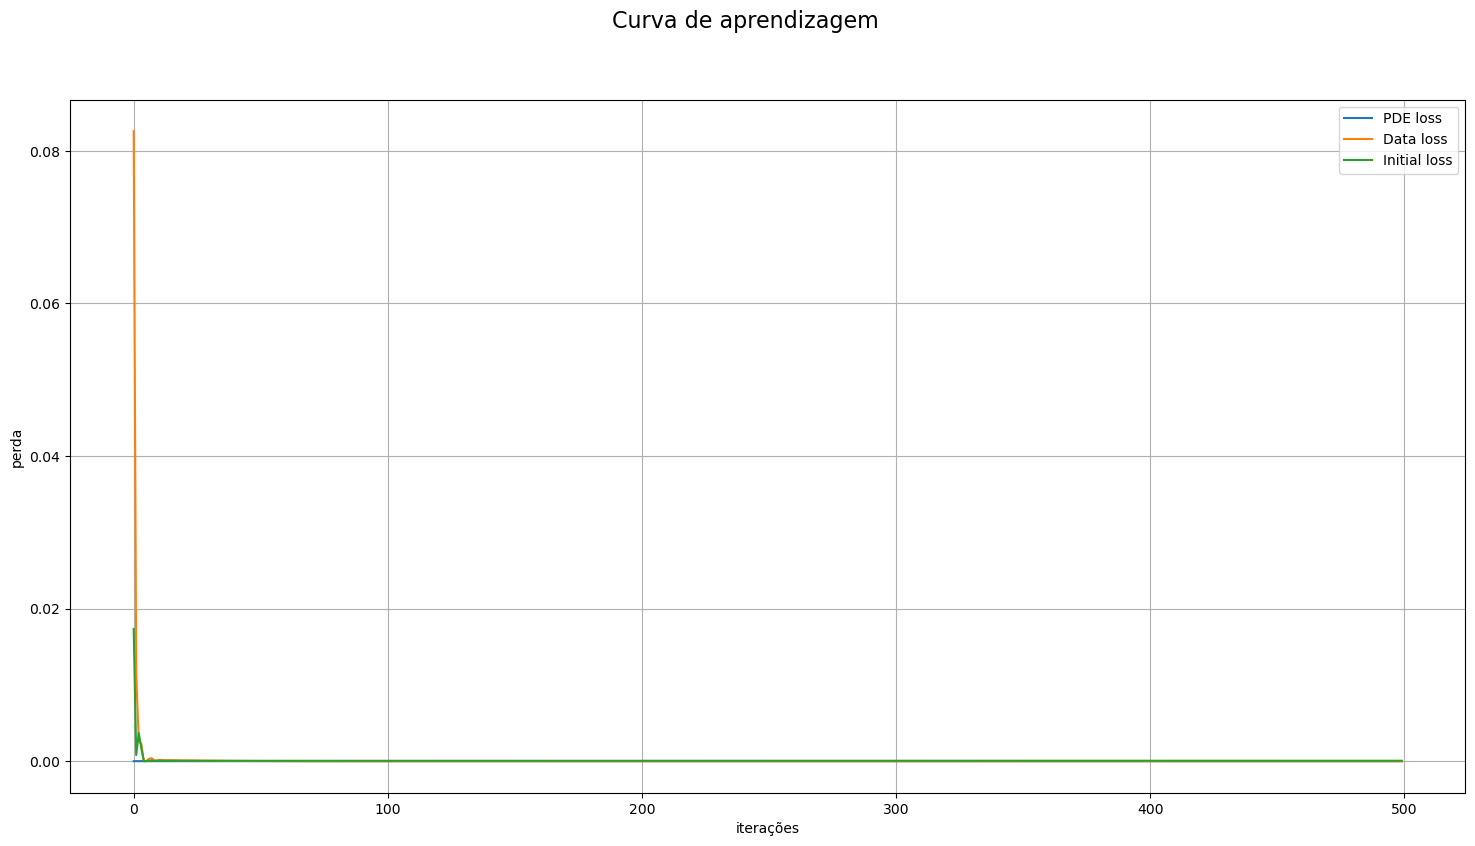

In [102]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_pde_loss_it.cpu().numpy())),C_pde_loss_it.cpu().numpy(),label="PDE loss")
ax.plot(range(len(C_data_loss_it.cpu().numpy())),C_data_loss_it.cpu().numpy(),label="Data loss")
ax.plot(range(len(C_initial_loss_it.cpu().numpy())),C_initial_loss_it.cpu().numpy(),label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [105]:
model_cpu = model.to('cpu')


speed_up = []


for i in range(33):
    
start = time.time()

with torch.no_grad():
        
    Cl_pinn,Cp_pinn = model_cpu(t).split(1,dim=1)

end = time.time()

In [ ]:
with open("edo_pinn_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cp_pinn, f)

with open("edo_pinn_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cl_pinn, f)


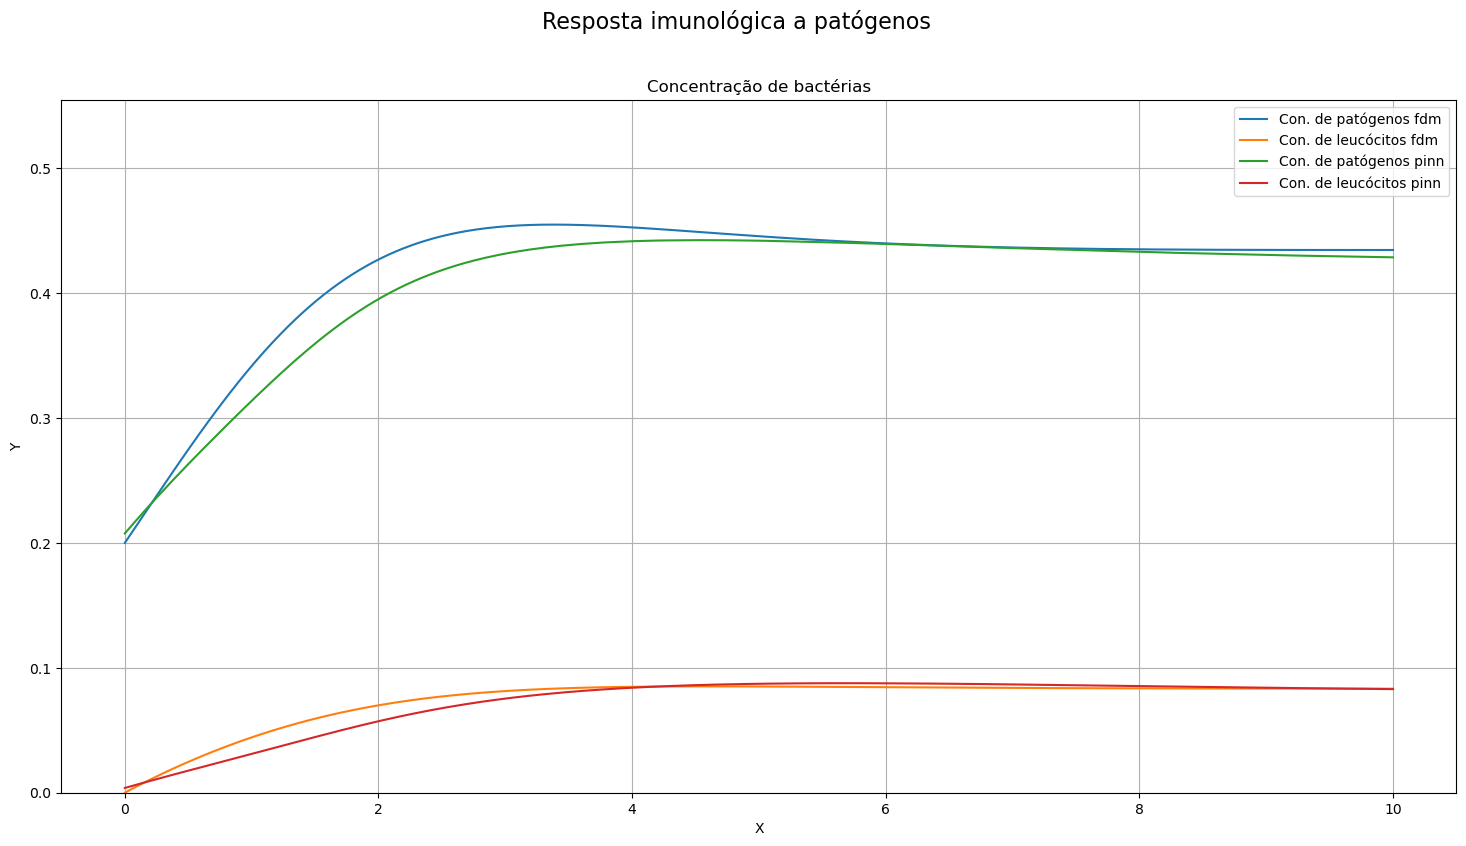

In [106]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(t.detach().numpy(), Cp, label="Con. de patógenos fdm")
ax.plot(t.detach().numpy(), Cl, label="Con. de leucócitos fdm")
ax.plot(t.detach().numpy(), Cp_pinn, label="Con. de patógenos pinn")
ax.plot(t.detach().numpy(), Cl_pinn, label="Con. de leucócitos pinn")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax+0.1)
ax.legend()
ax.grid()
plt.show()